In [1]:
import ROOT
ROOT.EnableImplicitMT()
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.stats import exponnorm, norm
import numpy as np
np.seterr(divide='ignore', invalid='ignore');

import hist
import pandas as pd
import uproot as ur
import mplhep as hep
hep.style.use('CMS')

Welcome to JupyROOT 6.28/00


In [2]:
BR_BKEE = 4.5E-7 # Using Mu BR from PDG instead of electron (5.6E-7)
BR_BJPSI = 1.02E-3
BR_JPSIEE = 5.97E-2

def get_eff_eek(df, bdt, get_unc=False, weights=False, total_mc=None):
    if weights:
        # k = df.Filter(f'(Mll > 1.05 && Mll < 2.45) && (Bmass > 5.1 && Bmass < 5.4) && Bcos > .85 && Bprob > 1E-6 && BsLxy > 3. && Kpt > 0.5 && L1id > -1.5 && L2id > -3 && L1pt > 2 && L2pt > 2 && xgb>{str(bdt)}').Sum(weights).GetValue()
        k = df.Filter(f'(Mll > 1.05 && Mll < 2.45) && (Bmass > 5.1 && Bmass < 5.4) && bdt_score_0>{str(bdt)}').Sum(weights).GetValue()
        n = df.Sum(weights).GetValue() if total_mc is None else total_mc #not the total sum but the same filter withuot BDT score adding tigger weight as well
    else:
        # k = df.Filter(f'(Mll > 1.05 && Mll < 2.45) && (Bmass > 5.1 && Bmass < 5.4) && Bcos > .85 && Bprob > 1E-6 && BsLxy > 3. && Kpt > 0.5 && L1id > -1.5 && L2id > -3 && L1pt > 2 && L2pt > 2 && xgb>{str(bdt)}').Count().GetValue()
        k = df.Filter(f'(Mll > 1.05 && Mll < 2.45) && (Bmass > 5.1 && Bmass < 5.4) && bdt_score_0>{str(bdt)}').Count().GetValue()
        n = df.Count().GetValue() if total_mc is None else total_mc
    
    try:
        eff = k / n
        unc = np.sqrt(eff * (1 - eff) / n) # Binomial stats
        # unc = eff * np.sqrt((1 / k) + (1 / n)) # Poisson stats
    except ZeroDivisionError:
        eff = 0
        unc = 0

    return (eff, unc) if get_unc else eff

def get_eff_jpsik(df, bdt, get_unc=False, weights=False, total_mc=None):
    if weights:
        # k = df.Filter(f'(Mll > 2.95 && Mll < 3.2) && (Bmass > 5.1 && Bmass < 5.4) && Bcos > .85 && Bprob > 1E-6 && BsLxy > 3. && Kpt > 0.5 && L1id > -1.5 && L2id > -3 && L1pt > 2 && L2pt > 2 && xgb>{str(bdt)}').Sum(weights).GetValue()
        k = df.Filter(f'(Mll > 2.95 && Mll < 3.2) && (Bmass > 5.1 && Bmass < 5.4) && bdt_score_0>{str(bdt)}').Sum(weights).GetValue()
        n = df.Sum(weights).GetValue() if total_mc is None else total_mc
    else:
        # k = df.Filter(f'(Mll > 2.95 && Mll < 3.2) && (Bmass > 5.1 && Bmass < 5.4) && Bcos > .85 && Bprob > 1E-6 && BsLxy > 3. && Kpt > 0.5 && L1id > -1.5 && L2id > -3 && L1pt > 2 && L2pt > 2 && xgb>{str(bdt)}').Count().GetValue()
        k = df.Filter(f'(Mll > 2.95 && Mll < 3.2) && (Bmass > 5.1 && Bmass < 5.4) && bdt_score_0>{str(bdt)}').Count().GetValue()
        n = df.Count().GetValue() if total_mc is None else total_mc
    try:
        eff = k / n
        unc = np.sqrt(eff * (1 - eff) / n) # Binomial stats
        # unc = eff * np.sqrt((1 / k) + (1 / n)) # Poisson stats
    except ZeroDivisionError:
        eff = 0
        unc = 0

    return (eff, unc) if get_unc else eff

def estimateTransferFactor(eff_eek, eff_jpsik):
    try:
        return BR_BKEE * eff_eek / (BR_BJPSI * BR_JPSIEE * eff_jpsik)
    except ZeroDivisionError:
        return 0


# estimateKEE = lambda x, eff_eek, eff_jpsik: x * BR_BKEE * eff_eek / (BR_BJPSI * BR_JPSIEE * eff_jpsik)
def estimateKEE(x, eff_eek, eff_jpsik):
    try:
        return x * BR_BKEE * eff_eek / (BR_BJPSI * BR_JPSIEE * eff_jpsik)
    except ZeroDivisionError:
        return 0

In [3]:
rdf = ROOT.RDataFrame('mytree', '/Users/con_np/Desktop/rs/r3k/r3k-bdttools/outputs/model_0/measurement_data.root',['Bmass','Mll','bdt_score_0']) #mytree instead of mytreefit
rdf_jpsi = ROOT.RDataFrame('mytree', '/Users/con_np/Desktop/rs/r3k/r3k-bdttools/outputs/model_0/measurement_jpsi.root',['Bmass','Mll','trig_wgt','bdt_score_0'])
rdf_rare = ROOT.RDataFrame('mytree', '/Users/con_np/Desktop/rs/r3k/r3k-bdttools/outputs/model_0/measurement_rare.root',['Bmass','Mll','trig_wgt','bdt_score_0'])

In [4]:
def get_bin(value, h_bins):
    bin_arr = np.linspace(h_bins[1], h_bins[2], h_bins[0], endpoint=False)
    return int(np.digitize(value, bin_arr))

def significance_scan(scanrange, verbosity=0):
    scores = np.array([]) #for ploting later
    sigs = np.array([])
    n_sigs = np.array([])
    n_bkgs = np.array([])
    
    h_bins = (50,4.8,5.6)
    low_bin_left = get_bin(4.95, h_bins)
    low_bin_right = get_bin(5.1, h_bins)
    up_bin_left = get_bin(5.4, h_bins)
    up_bin_right = get_bin(5.55, h_bins)

    for bdt in scanrange:
        h_sig = rdf.Filter(f'(Mll > 2.95 && Mll < 3.2) && bdt_score_0>{str(bdt)}').Histo1D(('Bmass',';;',*h_bins),'Bmass')
        low_sb_jpsi_bkg = h_sig.Integral(low_bin_left, low_bin_right)
        high_sb_jpsi_bkg = h_sig.Integral(up_bin_left, up_bin_right)
        jpsi_total = h_sig.Integral(low_bin_right, up_bin_left)
        n_sig_jpsi = jpsi_total - (low_sb_jpsi_bkg + high_sb_jpsi_bkg)
        
        h_bkg = rdf.Filter(f'(Mll > 1.05 && Mll < 2.45) && ((Bmass > 4.8 && Bmass < 5.1) || (Bmass > 5.4 && Bmass < 5.6)) && bdt_score_0>{str(bdt)}').Histo1D(('Bmass',';;',*h_bins),'Bmass')
        low_sb_ee_bkg = h_bkg.Integral(low_bin_left, low_bin_right)
        high_sb_ee_bkg = h_bkg.Integral(up_bin_left, up_bin_right)
        n_lowq_bkg = low_sb_ee_bkg + high_sb_ee_bkg

        eff_eek, eff_eek_unc = get_eff_eek(rdf_rare, bdt, get_unc=True, weights='trig_wgt', total_mc=500_000_000) #getting eff for rare.
        eff_jpsik, eff_jpsik_unc = get_eff_jpsik(rdf_jpsi, bdt, get_unc=True, weights='trig_wgt', total_mc=500_000_000) #getting off forr Jpsi
        #don't forget to go back to the function and chage xgb_old

        N_sig = estimateKEE(n_sig_jpsi, eff_eek, eff_jpsik) #0th argumennt= number of signals of Jpsi -> total gives the number of signal of Nrare
        N_bkg = n_lowq_bkg

        if N_sig and N_bkg:
            significance = N_sig / np.sqrt(N_sig + N_bkg) #calculating significance

            scores = np.append(scores, bdt) #i->bdt_score. Updating scores array (the same bdt_score)
            sigs = np.append(sigs, significance) #updating sigs array defined at the start
            n_sigs = np.append(n_sigs, N_sig)
            n_bkgs = np.append(n_bkgs, N_bkg)


    return scores, sigs, n_sigs, n_bkgs

In [5]:
score_scan = np.linspace(-5,5,20,endpoint=False) #endpoint=False -> not including 5

In [6]:
scores_0, sigs_0 = significance_scan(score_scan, verbosity=1)

In [83]:
np.savez_compressed('sig_score_0_3', scores_0=scores_0, sigs_0=sigs_0, scores_3=scores_3, sigs_3=sigs_3)

In [86]:
load = np.load('sig_score_default_6new.npz') #the original file does not have arrays for n_sigs and n_bkgs
scores_0, sigs_0 = load['scores_0'], load['sigs_0']
scores_3, sigs_3 = load['scores_3'], load['sigs_3']


In [42]:
# load = np.load('sig_score.npz') #the original file does not have arrays for n_sigs and n_bkgs
# scores_old_0, sigs_old_0 = load['scores_old'], load['sigs_old']
# # scores_new_0, sigs_new_0 = load['scores_new'], load['sigs_new']

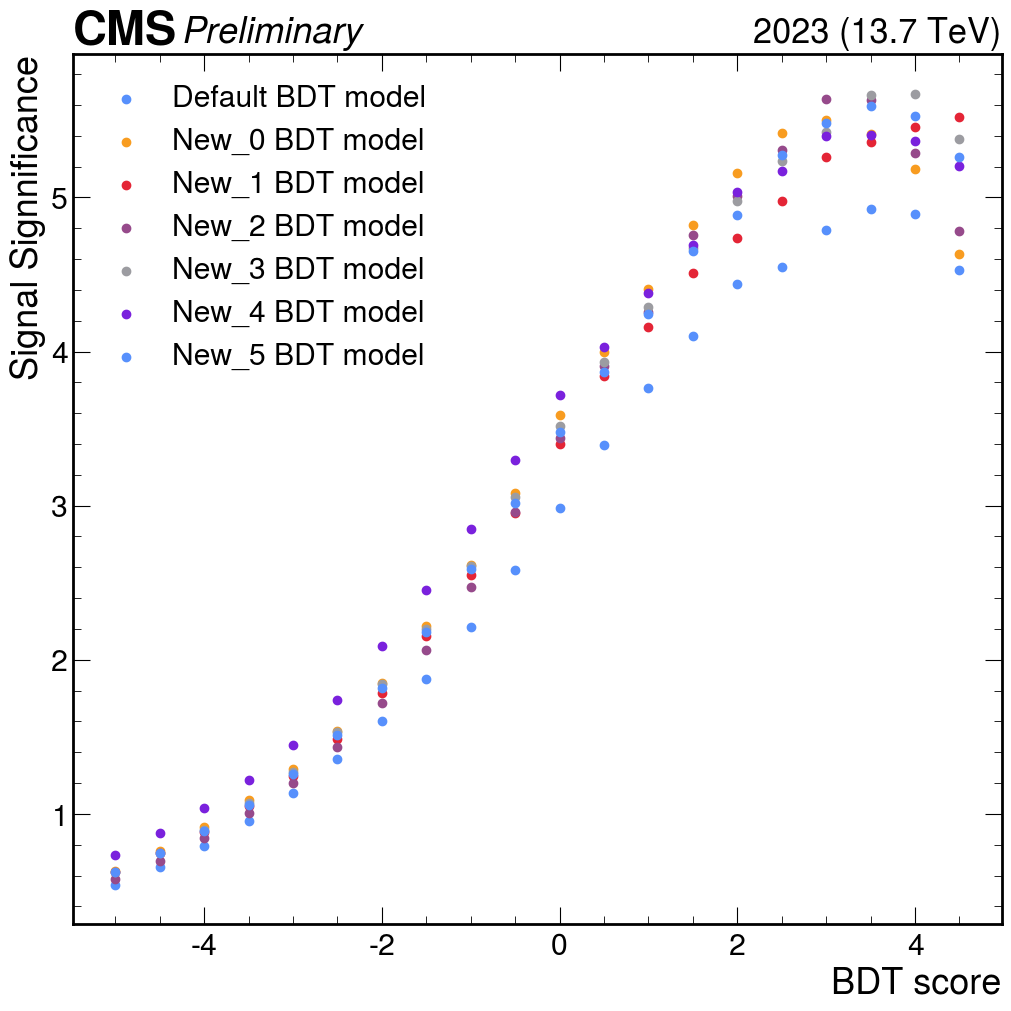

In [91]:
fig, ax = plt.subplots(layout="constrained") #constrained fix the savefig() to not cut the the plot
hep.cms.label('Preliminary', data=True, lumi=None, year=2023, com=13.7)

plt.scatter(scores_old,sigs_old, label='Default BDT model')
# plt.scatter(scores_old_0,sigs_old_0, label='Deafult_0 BDT model')
plt.scatter(scores_new_0,sigs_new_0, label='New_0 BDT model')
plt.scatter(scores_new_1,sigs_new_1, label='New_1 BDT model')
plt.scatter(scores_new_2,sigs_new_2, label='New_2 BDT model')
plt.scatter(scores_new_3,sigs_new_3, label='New_3 BDT model')
plt.scatter(scores_new_4,sigs_new_4, label='New_4 BDT model')
plt.scatter(scores_new_5,sigs_new_5, label='New_5 BDT model')
plt.xlabel('BDT score')
plt.ylabel('Signal Signnificance')
plt.legend()
plt.show()
#plt.savefig('yeild_newBDT')

In [89]:
def lorentzian(x, x0, gamma, A, B):
    return B + (2 * A / (np.pi * gamma)) / (1 + ((x - x0) / gamma) ** 2)

def polynomial(x, *coefficients):
    return np.polyval(coefficients, x)

def plot_lor_poly(scores, sigs, model):
    x_fit = np.linspace(min(scores), max(scores), 1000)
    
    #Lorentian
    initial_guess = [np.mean(scores), 1.0, 1.0, 0.0]
    lor_params, _ = curve_fit(lorentzian, scores, sigs, p0=initial_guess)
    lor_fit = lorentzian(x_fit, *lor_params)
    lor_opt = lor_params[0]

    #Polynomial
    N = 3
    initial_guess = np.ones(N + 1)  
    poly_params, _ = curve_fit(polynomial, scores, sigs, p0=initial_guess)
    poly_fit = polynomial(x_fit, *poly_params)
    poly_opt = x_fit[np.argmax(poly_fit)]

    plt.plot(x_fit, lor_fit, color='red', label=f'Lorentzian Fit {model}')
    #plt.axhline(max(lor_fit), color='red', linestyle='dotted', label=f'Lorentzian {model} Opt. Signal Significance cut ({round(max(lor_fit),2)})')
    plt.axvline(lor_opt, color='red', linestyle='dashed', label=f'Lorentzian {model} Opt. BDT cut ({round(lor_opt,2)})')

    plt.plot(x_fit, poly_fit, color='orange', label=f'Polynomial Fit {model}')
    #plt.axhline(max(poly_fit), color='orange', linestyle='dotted', label=f'Polynomial {model} Opt. Signal Significance cut ({round(max(poly_fit),2)})')
    plt.axvline(poly_opt, color='orange', linestyle='dashed', label=f'Polynomial {model} Opt. BDT cut ({round(poly_opt,2)})')
    
    plt.scatter(scores, sigs, label=f'Data {model}')

    plt.xlabel('BDT Score',loc='right')
    plt.ylabel(r'Signal Significance $(\frac{N_{Sig}}{\sqrt{N_{Sig} + N_{Bkg}}})$',loc='top')


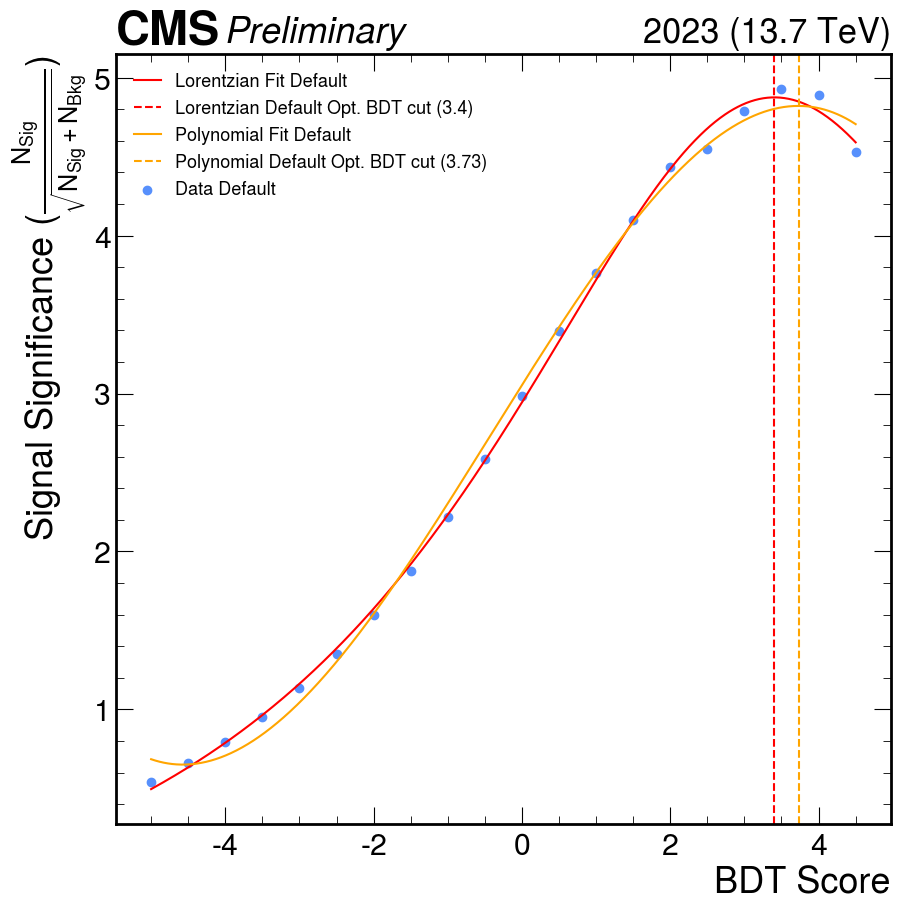

In [90]:
hep.cms.label('Preliminary', data=True, lumi=None, year=2023, com=13.7)
plot_lor_poly(scores_old, sigs_old, 'Default')
plt.legend(loc='upper left', fontsize=13)#loc='lower right')

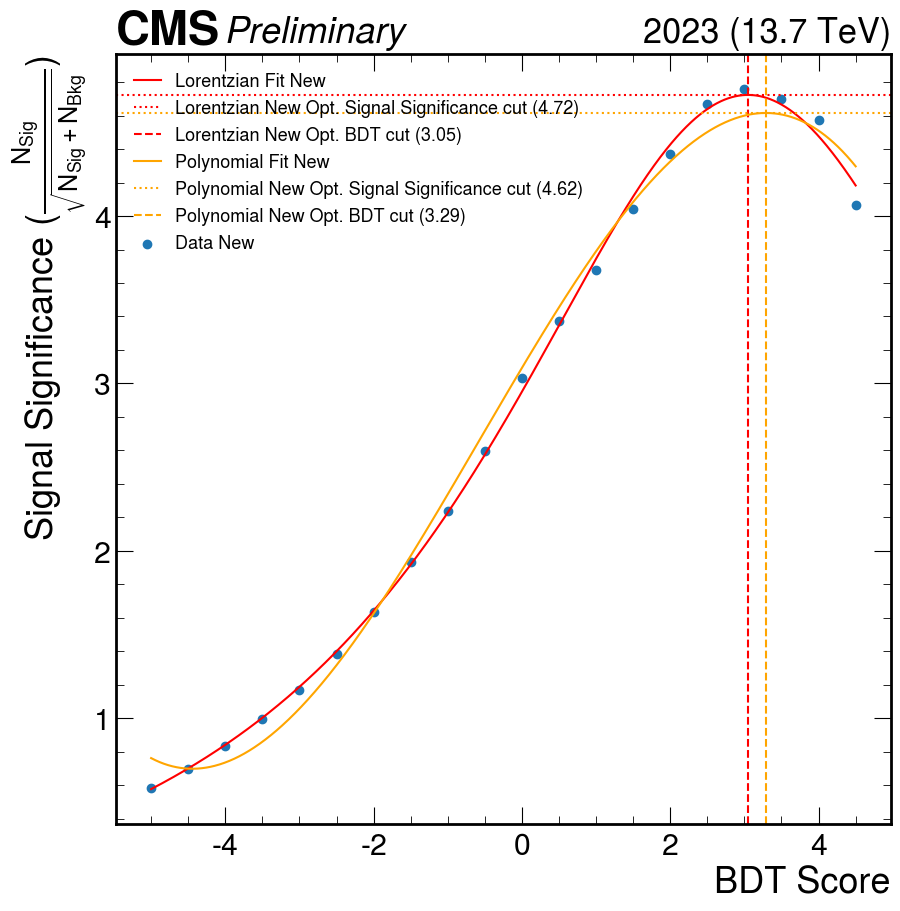

In [40]:
hep.cms.label('Preliminary', data=True, lumi=None, year=2023, com=13.7)
plot_lor_poly(scores_new, sigs_new, 'New')
plt.legend(loc='upper left', fontsize=13)#loc='lower right')

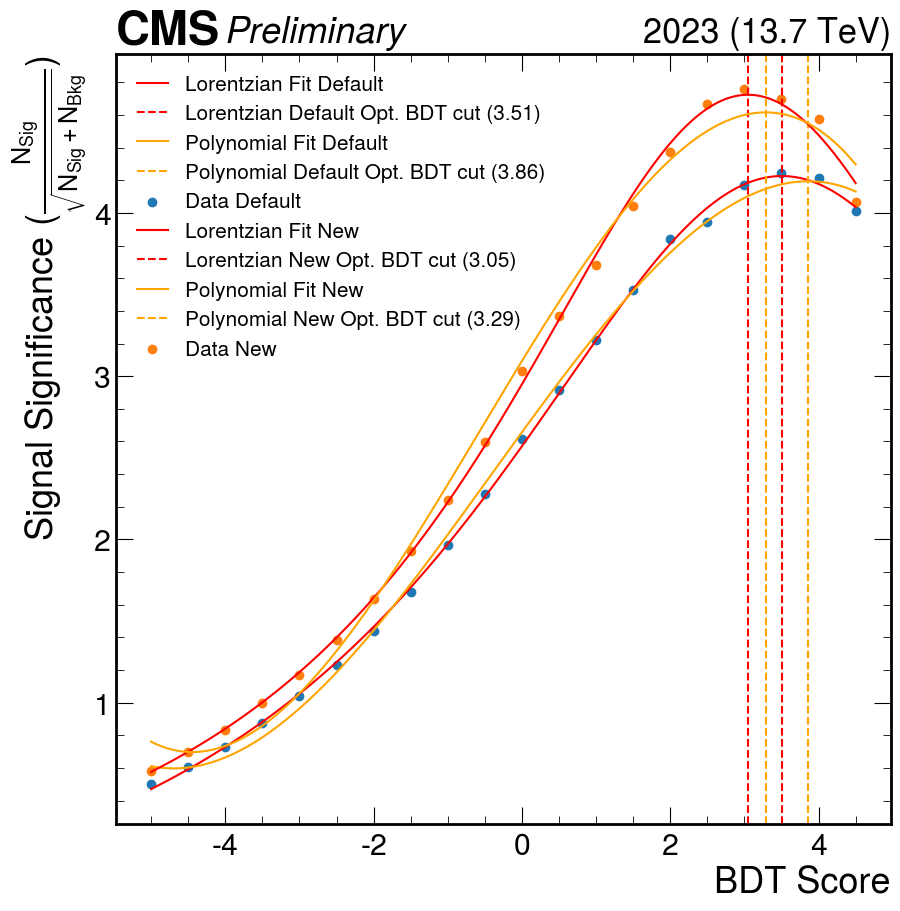

In [44]:
# changing scores -> old and new, sigs -> old and new
hep.cms.label('Preliminary', data=True, lumi=None, year=2023, com=13.7)
plot_lor_poly(scores_old, sigs_old, 'Default')
plot_lor_poly(scores_new, sigs_new, 'New')
plt.legend(loc='upper left', fontsize=15)#loc='lower right')


In [46]:
# def bmass_jpsi_hist(df, xgb, bins):
#     h_sig = rdf.Filter(f'(Mll > 2.95 && Mll < 3.2) && xgb_old>{str(xgb)}').Histo1D(('Bmass',';;',bins,4.8,5.6),'Bmass')
#     canvas_jpsi = ROOT.TCanvas("canvas_sig", "Jpsi Bmass", 800, 600)
#     h_sig.Draw()
#     h_sig.GetXaxis().SetTitle('Bmass')
#     h_sig.GetYaxis().SetTitle('nEvents')
#     canvas_jpsi.SetLogy()
#     canvas_jpsi.Draw()


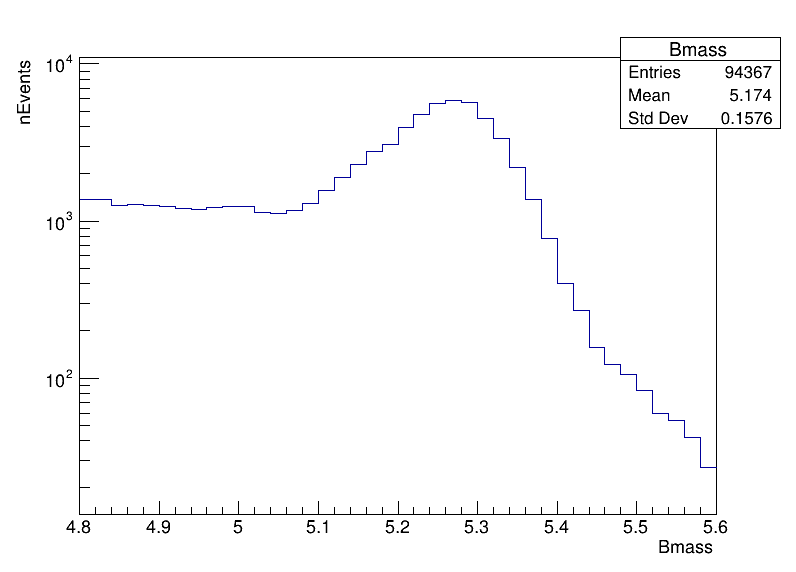

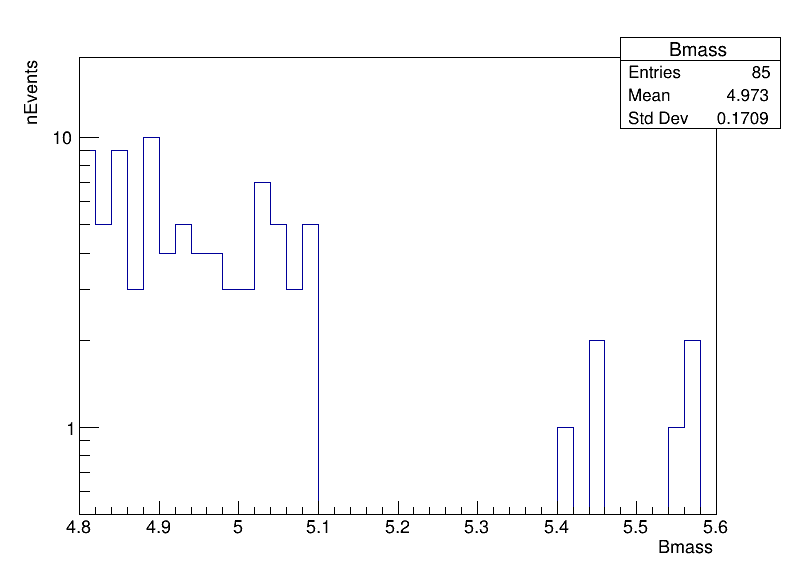

In [45]:
bins=40
xgb=4
h_sig = rdf.Filter(f'(Mll > 2.95 && Mll < 3.2) && xgb_old>{str(xgb)}').Histo1D(('Bmass',';;',bins,4.8,5.6),'Bmass')
h_bkg = rdf.Filter(f'(Mll > 1.05 && Mll < 2.45) && ((Bmass > 4.8 && Bmass < 5.1) || (Bmass > 5.4 && Bmass < 5.6)) && xgb_old>{str(xgb)}').Histo1D(('Bmass',';;',bins,4.8,5.6),'Bmass')

canvas_jpsi = ROOT.TCanvas("canvas_sig", "Jpsi Bmass", 800, 600)

h_sig.Draw()
h_sig.GetXaxis().SetTitle('Bmass')
h_sig.GetYaxis().SetTitle('nEvents')
canvas_jpsi.SetLogy()
canvas_jpsi.Draw()

canvas_data = ROOT.TCanvas("canvas_bkg", "Data Bmass", 800, 600)
h_bkg.Draw()
h_bkg.GetXaxis().SetTitle('Bmass')
h_bkg.GetYaxis().SetTitle('nEvents')

canvas_data.SetLogy()
canvas_data.Draw()


In [ ]:
index_peak = sigs_old.index(max(sigss_old))
n_sig_peak = n_sigs_old[index_peak]
n_bkg_old = n_bkgs_old[index_peak]